### Regge-Wheeler-Zerilli Evolution | Adaptive Characteristic Method
**Author**: Ken Sible | **Date**: March 11, 2019

<img src="images/adaptive_figure.png" width="2236" height="1258" align="center"/>

**Adaptive Characteristic Method Algorithm**

\begin{align}
    \text{Lower Resolution: }&\psi^{(LR)}\,(i\rightarrow i+1)\\
    \text{Higher Resolution, 1: }&\psi^{(HR,1)}\,(i\rightarrow i+1/2)\\
    \text{Higher Resolution, 2: }&\psi^{(HR,2)}\,(i+1/2\rightarrow i+1)
\end{align}
~~~~
# Define Constants, Functions, and Initial Conditions
while u[i] < u_max
    # Compute ψLR, ψHR[1], ψHR[2]
    ϵ = maximum(abs.(ψHR[2] - ψLR))
    if ϵ < tol
        push(ψ, ψLR)
        push(u, u[i] + du)
        i += 1
    end
    du *= (tol/ϵ)^(1/2)
end
~~~~

In [1]:
""" lambertw(z, [tol])

    Solves z = w * exp(w) for w using the Newton-Raphson method
    with the specified tolerance, assuming the principle branch.
"""
function lambertw(z::Number; tol::Real=1e-8)
    z < -1/ℯ && throw(DomainError())
    f(w) = w * exp(w) - z
    df(w) = exp(w) * (w + 1)
    w = z < 1 ? z : log(z)
    f(w) == 0 && return w
    begin i = 0
        while abs(f(w)) > tol
            w += -f(w)/df(w)
            (i += 1) > 1000 && break
        end
    end
    return w
end;

In [2]:
function rtwavefunc(dt::Real, dx::Real)
    T, L = 500, 500
    Nt = Int(T/dt) + 1
    Nx = Int(L/dx) + 1
    l = 3; λ = (l - 1)*(l + 2)/2
    x0 = 200 # Initial Pulse Position

    RWV(r) = (1 - 2/r)*((l + 1)l/r^2 - 6/r^3)
    pulse(x) = 0.5(exp(-(x - x0)^2/10))
    deriv(x) = 0.1(x0 - x) * pulse(x)
    t, x = 0:dt:T, -(L/2):dx:(L/2)
    r = [2(lambertw(exp((x_i - 2)/2)) + 1) for x_i ∈ x]
    
    # ψtt - ψxx + V(x)ψ = 0 | let ψ[1] = ψ, ψ[2] = ψt
    dψ(t, ψ, r, ψxx) = [ψ[2], ψxx - RWV(r) * ψ[1]]
    ψ = zeros(Nt, Nx, 2)
    ψ[1, :, :] = [pulse.(x) deriv.(x)]
    ψxx, ψ1 = zeros(Nx), zeros(Nx, 2)
    ψIS, ψFS = Float64[], Float64[]
    k1, k2 = zeros(Nx, 2), zeros(Nx, 2)
    for i = 1:(Nt - 1) # Ralston's Method
        for j = 2:(Nx - 1)
            ψxx[j] = (ψ[i, j + 1, 1] - 2ψ[i, j, 1] + ψ[i, j - 1, 1])/dx^2
            k1[j, :] = dψ(t[i], ψ[i, j, :], r[j], ψxx[j])
            ψ1[j, :] = ψ[i, j, :] + k1[j, :]*(2/3)*dt
        end
        for j = 2:(Nx - 1)
            ψxx[j] = (ψ1[j + 1, 1] - 2ψ1[j, 1] + ψ1[j - 1, 1])/dx^2
            k2[j, :] = dψ(t[i] + (2/3)*dt, ψ1[j, :], r[j], ψxx[j])
            ψ[i + 1, j, :] = ψ[i, j, :] + dt*(k1[j, :] + 3*k2[j, :])/4
            
            v = round(t[i] + x[j], digits=2)
            if round(x[j] - t[i], digits=2) == 150 && 150 <= v <= 250
                push!(ψIS, ψ[i, j, 1])
            end
            if round(x[j] - t[i], digits=2) == -500 && 150 <= v <= 250
                push!(ψFS, ψ[i, j, 1])
            end
        end
    end

    return ψ[:, :, 1], ψIS, ψFS, x
end;

In [3]:
function uvwavefunc(du::Real, dv::Real, ψ0::Vector{<:Real}; tol=1e-6)
    U, V = 500, 100
    Nu = Int(U/du) + 1
    Nv = Int(V/dv) + 1
    l = 3; λ = (l - 1)*(l + 2)/2
    v0 = 300 # Initial Pulse Position

    RWV(r) = (1 - 2/r)*((l + 1)l/r^2 - 6/r^3)
    pulse(v) = 0.5(exp(-(v - v0)^2/10))
    r(x) = 2(lambertw(exp((x - 2)/2)) + 1)

    i, u = 1, [0.0]
    v = (v0 - 50):dv:(v0 + 50)
    ψ = zeros(1, Nv); ψ[1, :] = ψ0
    ψLR, ψHR = zeros(Nv), zeros(2, Nv)

    while u[i] < U
        for j = 1:(Nv - 1)
            x = ((v[j + 1] + v[j]) - ((u[i] + du) + u[i]))/4
            α = 1 - (du * dv)/8 * RWV(r(x))
            ψLR[j + 1] = α * (ψLR[j] + ψ[i, j + 1]) - ψ[i, j]

            x = ((v[j + 1] + v[j]) - ((u[i] + du/2) + u[i]))/4
            α = 1 - (du/2 * dv)/8 * RWV(r(x))
            ψHR[1, j + 1] = α * (ψHR[1, j] + ψ[i, j + 1]) - ψ[i, j]

            x = ((v[j + 1] + v[j]) - ((u[i] + du) + (u[i] + du/2)))/4
            α = 1 - (du/2 * dv)/8 * RWV(r(x))
            ψHR[2, j + 1] = α * (ψHR[2, j] + ψHR[1, j + 1]) - ψHR[1, j]
        end
        ϵ = maximum(abs.(ψHR[2, :] - ψLR))
        if ϵ < tol
            ψ = [ψ; ψLR']
            push!(u, u[i] + du)
            i += 1
        end
        du *= (tol/ϵ)^(1/2)
    end

    return ψ, v
end;

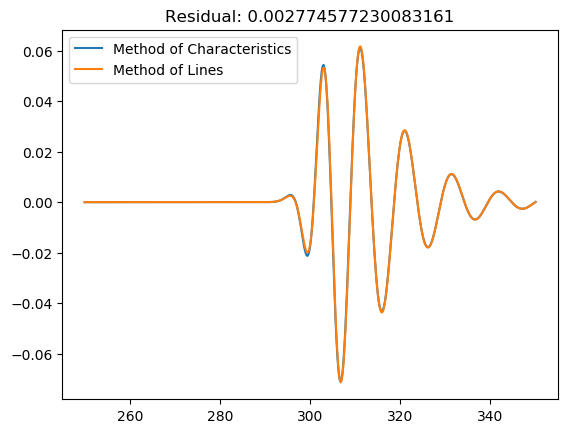

In [4]:
using PyPlot

dt, dx = 0.025, 0.1
ψ, ψIS, ψFS, x = rtwavefunc(dt, dx)

du, dv = 0.2, 0.2
ψuv, v = uvwavefunc(du, dv, ψIS)

plot(v, ψuv[end, :], label="Method of Characteristics")
plot(v, ψFS, label="Method of Lines")
res = maximum(abs.(ψuv[end, :] .- ψFS))
plt[:title]("Residual: $res"); plt[:legend]();